In [162]:
from elasticsearch import Elasticsearch
from collections import Counter, defaultdict
import pandas as pd
import pyupset as pyu
import re
import itertools
import json
import matplotlib as plt
from IPython.display import set_matplotlib_formats

# %matplotlib inline
%matplotlib inline

In [163]:
es = Elasticsearch()

In [164]:
res = es.search(index="g2p", size=10000, body={"query": {"match_all": {}}})

In [165]:
def collect_all_results():
    res = es.search(index="g2p", size=10000, body={"query": {"match_all": {}}}, scroll='1m')
    scroll_id = res.get('_scroll_id')
    i = 1
    while scroll_id is not None:
        print('Processing scroll {}'.format(i))
        r = es.scroll(scroll_id)
        scroll_id = r.get('_scroll_id')
        res['hits']['hits'] += r['hits']['hits']
        i += 1
    return res
        

In [166]:
res = collect_all_results()

Processing scroll 1


# Total Associations

In [167]:
assert len(res['hits']['hits']) == res['hits']['total']
len(res['hits']['hits'])

17469

In [168]:
def count_attribute(result, attribute):
    c = Counter([x['_source'][attribute] for x in result['hits']['hits']])
    return c

def count_attribute_by_group(result, attribute, group):
    d = dict()
    for g in count_attribute(result, group):
        d[g] = Counter([x['_source'][attribute] for x in result['hits']['hits'] if x['_source'][group] == g])
    return d

def count_list_attribute(result, list_attribute):
    c = Counter([attribute for x in result['hits']['hits'] for attribute in x['_source'][list_attribute]])
    return c

def count_list_attribute_by_group(result, list_attribute, group):
    d = dict()
    for g in count_attribute(result, group):
        d[g] = Counter([attribute for x in result['hits']['hits'] for attribute in x['_source'][list_attribute] if x['_source'][group] == g])
    return d

In [169]:
count_attribute(res, 'source')

Counter({'cgi': 1429,
         'civic': 2713,
         'jax': 6513,
         'molecularmatch': 2083,
         'oncokb': 4125,
         'pmkb': 606})

# Genes

In [170]:
%%capture
count_list_attribute(res, 'genes')

In [171]:
d = count_list_attribute_by_group(res, 'genes', 'source')

CGI has some genotype "genes" (e.g. 'ARID1A;ANXA1' from ARID1A amplification + ANXA1 overexpression)

CKB have some multi-gene molecular profiles. Example: https://ckb.jax.org/molecularProfile/show/26172

In [172]:
multi_gene_hits = [x for x in res['hits']['hits'] if len(x['_source']['genes']) >= 2]
s = Counter([x['_source']['source'] for x in multi_gene_hits])
s

Counter({'cgi': 45, 'jax': 2492, 'molecularmatch': 15})

In [173]:
mp_d = dict()
for source in s:
    mp_d[source] = set([tuple(sorted(x['_source']['genes'])) for x in res['hits']['hits'] if (len(x['_source']['genes']) >= 2) and (x['_source']['source'] == source)])

In [174]:
%%capture
mp_d

In [175]:
def overlap(group_counts):
    columns = sorted(group_counts) + ['Total']
    sets = {g: set(group_counts[g]) for g in group_counts}
    for g in sets:
        total = set()
        for s in sets:
            l = len(sets[g])
            if s != g:
                o = (sets[g] & sets[s])
                total |= sets[s]
            else:
                continue
            print('{} has {}/{} ({:.2f}%) overlap with {}'.format(g, len(o), l, len(o) / l * 100, s))
        o = (sets[g] & total)
        print('{} has {}/{} ({:.2f}%) overlap overall'.format(g, len(o), l, len(o) / l * 100, s))

In [176]:
overlap(d)

molecularmatch has 62/109 (56.88%) overlap with cgi
molecularmatch has 39/109 (35.78%) overlap with jax
molecularmatch has 68/109 (62.39%) overlap with civic
molecularmatch has 69/109 (63.30%) overlap with oncokb
molecularmatch has 22/109 (20.18%) overlap with pmkb
molecularmatch has 76/109 (69.72%) overlap overall
cgi has 62/181 (34.25%) overlap with molecularmatch
cgi has 59/181 (32.60%) overlap with jax
cgi has 121/181 (66.85%) overlap with civic
cgi has 131/181 (72.38%) overlap with oncokb
cgi has 37/181 (20.44%) overlap with pmkb
cgi has 151/181 (83.43%) overlap overall
jax has 39/106 (36.79%) overlap with molecularmatch
jax has 59/106 (55.66%) overlap with cgi
jax has 73/106 (68.87%) overlap with civic
jax has 75/106 (70.75%) overlap with oncokb
jax has 37/106 (34.91%) overlap with pmkb
jax has 84/106 (79.25%) overlap overall
civic has 68/290 (23.45%) overlap with molecularmatch
civic has 121/290 (41.72%) overlap with cgi
civic has 73/290 (25.17%) overlap with jax
civic has 145/2

In [177]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g].keys()), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = ['attribute'], inters_size_bounds=(1, 40000))

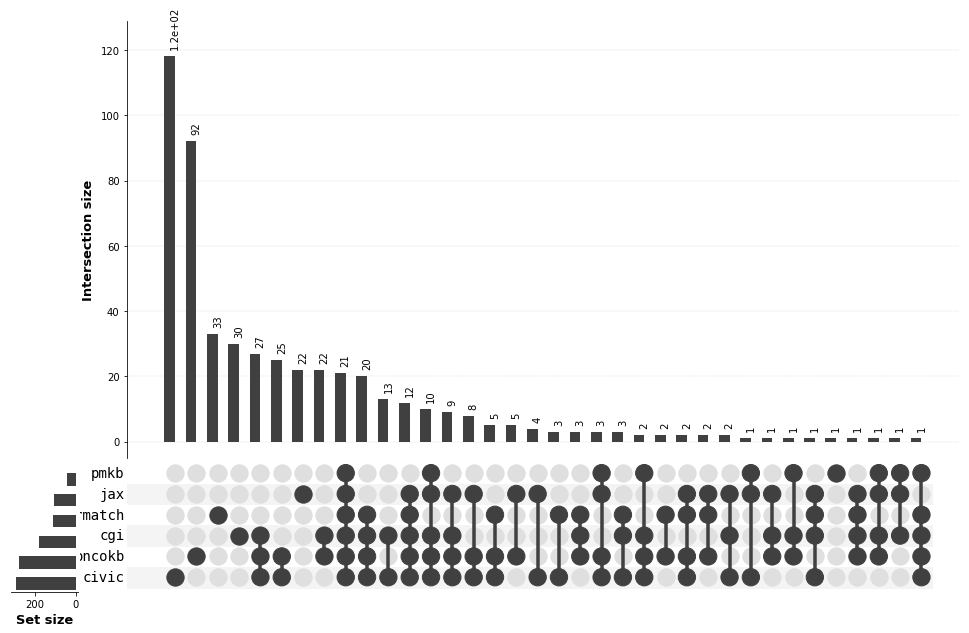

In [178]:
plot_overlap(d)
plt.pyplot.savefig('genes.png')

# Overlap of associations (drug + gene + phenotype)

Some hits (example here is from CGI) have strange behavior on drug normalization:

In [179]:
res['hits']['hits'][0]['_source']['association']['environmentalContexts']

[{'description': 'Icotinib',
  'id': 'compound:CID22024915',
  'taxonomy': {'class': 'Diazanaphthalenes',
   'direct-parent': 'Quinazolinamines',
   'kingdom': 'Organic compounds',
   'subclass': 'Benzodiazines',
   'superclass': 'Organoheterocyclic compounds'},
  'term': 'Icotinib',
  'toxicity': 'The most common toxicities reported are skin-related events and diarrhea.'}]

"Inhibitor" drug: https://pubchem.ncbi.nlm.nih.gov/compound/diacylglycerol_kinase_inhibitor_ii#section=Top

In [180]:
def select_failures(hits):
    pheno_failed = 0
    drug_failed = 0
    gene_failed = 0
    for hit in hits:
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
        except:
            print( "Gene failure on ID {}".format( hit['_id']))
            gene = None
        try:
            drug = '|'.join(sorted([x['id'] for x in hit['_source']['association']['environmentalContexts']]))
        except:
            print( "Drug failure on ID {}".format( hit['_id'] ))
            drug_failed += 1
            drug = None
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if gene is None or drug is None or phenotype is None:
            yield(hit)
        # yield (gene,drug,phenotype)
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} hits with failed drug'.format(drug_failed))
    print('{} total hits'.format(len(hits)))

In [181]:
def failure_types_by_source(hits):
    failures = defaultdict(Counter)
    totals = Counter()
    for hit in hits:
        totals[hit['_source']['source']] += 1
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
        except:
            failures[hit['_source']['source']]['gene'] += 1
        try:
            drug = '|'.join(sorted([x['id'] for x in hit['_source']['association']['environmentalContexts']]))
        except:
            failures[hit['_source']['source']]['drug'] += 1
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            failures[hit['_source']['source']]['phenotype'] += 1
    return failures, totals

In [182]:
%%capture
failed = list(select_failures(res['hits']['hits']))

In [183]:
print("{:.2f}% of associations not fully normalized across gene, drug, phenotype".format(len(failed) / len(res['hits']['hits']) * 100))

8.35% of associations not fully normalized across gene, drug, phenotype


In [184]:
c = Counter([x['_source']['source'] for x in failed])
c

Counter({'cgi': 392,
         'civic': 75,
         'jax': 316,
         'molecularmatch': 31,
         'oncokb': 39,
         'pmkb': 606})

In [185]:
def percent(num, den):
    return "{:.2f}%".format(num / den * 100)

d = count_attribute(res, 'source')
{source: percent(c[source], d[source]) for source in c}

{'cgi': '27.43%',
 'civic': '2.76%',
 'jax': '4.85%',
 'molecularmatch': '1.49%',
 'oncokb': '0.95%',
 'pmkb': '100.00%'}

In [186]:
failures = failure_types_by_source(res['hits']['hits'])
print('Drug failures:')
{source: percent(failures[0][source]['drug'], failures[1][source]) for source in failures[0]}

Drug failures:


{'cgi': '9.10%',
 'civic': '0.77%',
 'jax': '4.82%',
 'molecularmatch': '1.34%',
 'oncokb': '0.46%',
 'pmkb': '100.00%'}

In [187]:
print('Phenotype failures:')
{source: percent(failures[0][source]['phenotype'], failures[1][source]) for source in failures[0]}

Phenotype failures:


{'cgi': '21.13%',
 'civic': '2.03%',
 'jax': '0.03%',
 'molecularmatch': '0.14%',
 'oncokb': '0.48%',
 'pmkb': '12.71%'}

PMKB interpretations (https://pmkb.weill.cornell.edu/therapies) do not list drugs.

In [188]:
pmkb = [x for x in failed if x['_source']['source'] == 'pmkb']
pmkb[0]['_source']['association']

{'description': 'KIT(cKIT) mutations are present in approximatley 8-25% of cases of acute myeloid leukemia and  have a higher prevalence in the favorable cytogenetic risk group (t(8;21)(q22;q22)(RUNX1-RUNX1T1),  inv(16)(p13q22)(CBFB-MYH11) or normal karyotype.   Mutations of KIT in AML are  most common in KIT exon 17 (within the activation loop of the tyrosine kinase domain) but may also occur in KIT exons 8(extracellular portion of the receptor implicated in dimerization), 9-11 (juxtamembrane/transmembrane domains).  The presence of KIT mutations in patients with t(8;21)(q22;q22)(RUNX1-RUNX1T1) has been reported to be associated with a  poorer survival than expected for patients with the  t(8;21)(q22;q22) who do not carry a KIT mutation; however, on the other hand, several published studies have not shown an effect on survival/outcome.   KIT mutations are also important in systemic mastocytosis  and various mast cell disorders;  over 90% of cases of systemic mastocytosis carry mutatio

In [189]:
any(['environmentalContexts' in x['_source']['association'] for x in pmkb])

False

# Overlap of associations (gene + phenotype)

In [190]:
def select_failures(hits):
    pheno_failed = 0
    for hit in hits:
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
        except:
            gene = ''
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if phenotype is None:
            yield(hit)
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} total hits'.format(len(hits)))

In [191]:
%%capture
failed = list(select_failures(res['hits']['hits']))

In [192]:
print("{:.2f}% of associations not fully normalized across gene, phenotype".format(len(failed) / len(res['hits']['hits']) * 100))

2.63% of associations not fully normalized across gene, phenotype


In [193]:
c = Counter([x['_source']['source'] for x in failed])
c

Counter({'cgi': 302,
         'civic': 55,
         'jax': 2,
         'molecularmatch': 3,
         'oncokb': 20,
         'pmkb': 77})

In [194]:
d = count_attribute(res, 'source')
{source: percent(c[source], d[source]) for source in c}

{'cgi': '21.13%',
 'civic': '2.03%',
 'jax': '0.03%',
 'molecularmatch': '0.14%',
 'oncokb': '0.48%',
 'pmkb': '12.71%'}

Prostate Adenocarcinoma?

In [195]:
cgi = [x for x in failed if x['_source']['source'] == 'cgi']
cgi[0]['_source']['association']

{'description': 'ALK Crizotinib (ALK inhibitor) Responsive',
 'drug_labels': 'CRIZOTINIB',
 'environmentalContexts': [{'approved_countries': ['Canada', 'US'],
   'description': 'CRIZOTINIB',
   'id': 'compound:CID11626560',
   'taxonomy': {'class': 'Pyridines and derivatives',
    'direct-parent': 'Pyrazolylpyridines',
    'kingdom': 'Organic compounds',
    'subclass': 'Pyrazolylpyridines',
    'superclass': 'Organoheterocyclic compounds'},
   'term': 'CRIZOTINIB',
   'usan_stem': 'tyrosine kinase inhibitors'}],
 'evidence': [{'description': 'Responsive',
   'evidenceType': {'sourceName': 'cgi'},
   'info': {'publications': ['http://www.ncbi.nlm.nih.gov/pubmed/22072639']}}],
 'evidence_label': 'D',
 'evidence_level': 4,
 'phenotype': {'description': 'G'},
 'publication_url': 'http://www.ncbi.nlm.nih.gov/pubmed/22072639',
 'response_type': 'Responsive'}

In [196]:
cgi[0]['_source']['cgi']

'{"Targeting": "", "Biomarker": "ALK (R1275Q,G1128A,I1171N,R1192P,F1245C)", "Source": "PMID:22072639", "cDNA": "c.3824G>A", "Primary Tumor type": "G", "individual_mutation": "ALK:p.R1275Q", "Drug full name": "Crizotinib (ALK inhibitor)", "Association": "Responsive", "Drug family": "ALK inhibitor", "Curator": "RDientsmann", "Drug": "Crizotinib", "Alteration": "ALK:R1275Q,G1128A,I1171N,R1192P,F1245C", "gDNA": "chr2:g.29432664C>T", "Drug status": "", "Gene": "ALK", "transcript": "ENST00000389048", "strand": "-", "info": "CSQN=Missense;reference_codon=CGA;candidate_codons=CAA,CAG;candidate_mnv_variants=chr2:g.29432663_29432664delTCinsCT;aliases=ENSP00000373700;source=Ensembl", "Assay type": "", "Alteration type": "MUT", "region": "inside_[cds_in_exon_25]", "Evidence level": "Pre-clinical", "gene": "ALK", "Metastatic Tumor Type": ""}'

In [197]:
%%capture
set([x['_source']['association']['phenotype']['description'] for x in cgi])

In [198]:
def select_successes(hits):
    pheno_failed = 0
    for hit in hits:
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
            hit['merged'] = {'gene': gene}
        except:
            hit['merged'] = {'gene': ''}
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if phenotype is None:
            continue
        hit['merged']['phenotype'] = phenotype
        yield hit
        
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} total hits'.format(len(hits)))

In [199]:
%%capture
successes = list(select_successes(res['hits']['hits']))

In [200]:
s = Counter([x['_source']['source'] for x in successes])
s

Counter({'cgi': 1127,
         'civic': 2658,
         'jax': 6511,
         'molecularmatch': 2080,
         'oncokb': 4105,
         'pmkb': 529})

In [201]:
success_by_source = dict()
for source in s:
    success_by_source[source] = set([(x['merged']['gene'], x['merged']['phenotype']) for x in successes if x['_source']['source'] == source])

In [202]:
%%capture
success_by_source

In [203]:
overlap(success_by_source)

molecularmatch has 31/160 (19.38%) overlap with cgi
molecularmatch has 31/160 (19.38%) overlap with jax
molecularmatch has 37/160 (23.12%) overlap with civic
molecularmatch has 9/160 (5.62%) overlap with oncokb
molecularmatch has 2/160 (1.25%) overlap with pmkb
molecularmatch has 50/160 (31.25%) overlap overall
cgi has 31/289 (10.73%) overlap with molecularmatch
cgi has 83/289 (28.72%) overlap with jax
cgi has 87/289 (30.10%) overlap with civic
cgi has 58/289 (20.07%) overlap with oncokb
cgi has 16/289 (5.54%) overlap with pmkb
cgi has 139/289 (48.10%) overlap overall
jax has 31/886 (3.50%) overlap with molecularmatch
jax has 83/886 (9.37%) overlap with cgi
jax has 190/886 (21.44%) overlap with civic
jax has 76/886 (8.58%) overlap with oncokb
jax has 34/886 (3.84%) overlap with pmkb
jax has 253/886 (28.56%) overlap overall
civic has 37/757 (4.89%) overlap with molecularmatch
civic has 87/757 (11.49%) overlap with cgi
civic has 190/757 (25.10%) overlap with jax
civic has 55/757 (7.27%) 

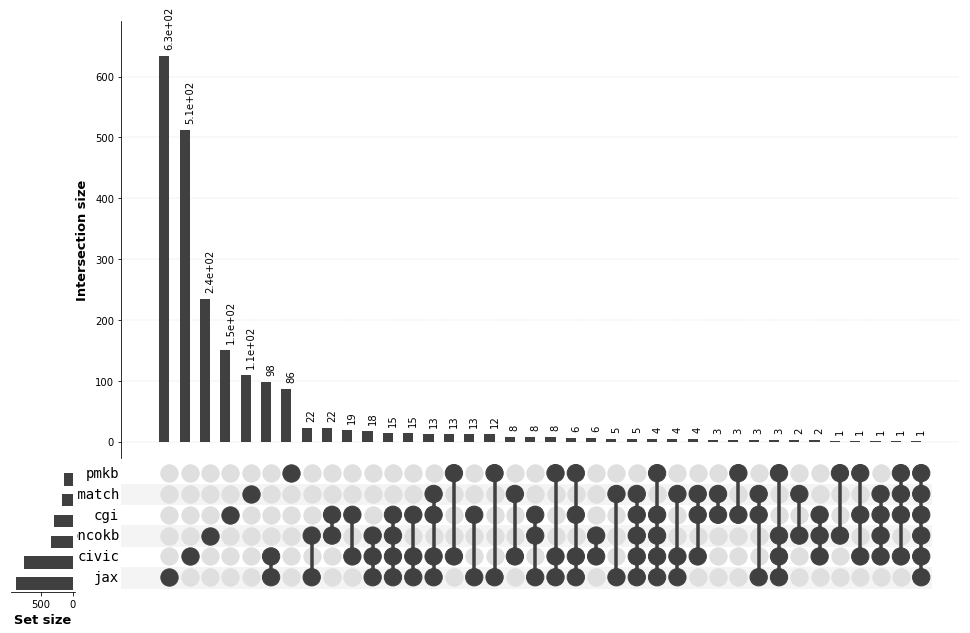

In [204]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g]), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = column_names, inters_size_bounds=(1, 4000))
    
plot_overlap(success_by_source, column_names=['gene', 'phenotype'])
plt.pyplot.savefig('gp_overlap.png')


## Finding gene-PMID associations and comparing to gene-phenotype

This is some debugging code for issue 41: https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41

In [47]:
double_listed_refs = Counter()
single_listed_refs = Counter()

listed_evidence = Counter()
single_evidence = Counter()
for hit in res['hits']['hits']:
    if isinstance(hit['_source']['association']['evidence'], list):
        listed_evidence[hit['_source']['source']] += 1
        for evidence in hit['_source']['association']['evidence']:
            for pmid_url in evidence['info']['publications']:
                if isinstance(pmid_url, list):
                    double_listed_refs[hit['_source']['source']] += 1
                else:
                    single_listed_refs[hit['_source']['source']] += 1
    else:
        single_evidence[hit['_source']['source']] += 1
        evidence = hit['_source']['association']['evidence']
        for pmid_url in evidence['info']['publications']:
            if isinstance(pmid_url, list):
                double_listed_refs[hit['_source']['source']] += 1
            else:
                single_listed_refs[hit['_source']['source']] += 1

In [48]:
print(double_listed_refs)
print(single_listed_refs)
print(listed_evidence)
print(single_evidence)

Counter()
Counter({'oncokb': 8321, 'jax': 6338, 'molecularmatch': 3894, 'pmkb': 3679, 'civic': 2713, 'cgi': 1859})
Counter({'jax': 6513, 'oncokb': 4125, 'civic': 2713, 'molecularmatch': 2083, 'cgi': 1429, 'pmkb': 606})
Counter()


First, we'll look at just PMID overlap

In [49]:
pmid_re = re.compile(r'https?://www.ncbi.nlm.nih.gov/pubmed/(\d+)')
source_pmids = defaultdict(set)
single_url = Counter()
listed_url = Counter()
for hit in res['hits']['hits']:
    pmids = set()
    # next two lines fix double_listing, see https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41
    if not isinstance(hit['_source']['association']['evidence'], list):
        hit['_source']['association']['evidence'] = [hit['_source']['association']['evidence']]
    for evidence in hit['_source']['association']['evidence']:
        urls = evidence['info']['publications']
    # next two lines fix single_evidence, see https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41
        if urls and isinstance(urls[0], list):
            urls = itertools.chain.from_iterable(urls)
        for pmid_url in urls:
            match = pmid_re.match(pmid_url)
            if match:
                pmids.add(match.groups()[0])
    urls = hit['_source']['association'].get('publication_url')
    # the following lines document differences in the structure of the publication_url field
    if not isinstance(urls, list):
        single_url[hit['_source']['source']] += 1
        urls = [urls]
    else:
        listed_url[hit['_source']['source']] += 1
    for url in urls:
        if url is None:
            continue
        match = pmid_re.match(url)
        if match:
            pmids.add(match.groups()[0])
    source_pmids[hit['_source']['source']] |= pmids
    pmids = list(pmids)
    if 'merged' in hit:
        hit['merged']['pmids'] = pmids
    else:
        hit['merged'] = {'pmids': pmids}
    

In [50]:
{k: len(v) for k, v in source_pmids.items()}

{'cgi': 566,
 'civic': 1431,
 'jax': 1334,
 'molecularmatch': 407,
 'oncokb': 3171,
 'pmkb': 335}

In [51]:
overlap(source_pmids)

molecularmatch has 67/407 (16.46%) overlap with cgi
molecularmatch has 110/407 (27.03%) overlap with jax
molecularmatch has 126/407 (30.96%) overlap with civic
molecularmatch has 113/407 (27.76%) overlap with oncokb
molecularmatch has 20/407 (4.91%) overlap with pmkb
molecularmatch has 236/407 (57.99%) overlap overall
cgi has 67/566 (11.84%) overlap with molecularmatch
cgi has 135/566 (23.85%) overlap with jax
cgi has 158/566 (27.92%) overlap with civic
cgi has 141/566 (24.91%) overlap with oncokb
cgi has 15/566 (2.65%) overlap with pmkb
cgi has 301/566 (53.18%) overlap overall
jax has 110/1334 (8.25%) overlap with molecularmatch
jax has 135/1334 (10.12%) overlap with cgi
jax has 217/1334 (16.27%) overlap with civic
jax has 199/1334 (14.92%) overlap with oncokb
jax has 32/1334 (2.40%) overlap with pmkb
jax has 441/1334 (33.06%) overlap overall
civic has 126/1431 (8.81%) overlap with molecularmatch
civic has 158/1431 (11.04%) overlap with cgi
civic has 217/1431 (15.16%) overlap with jax

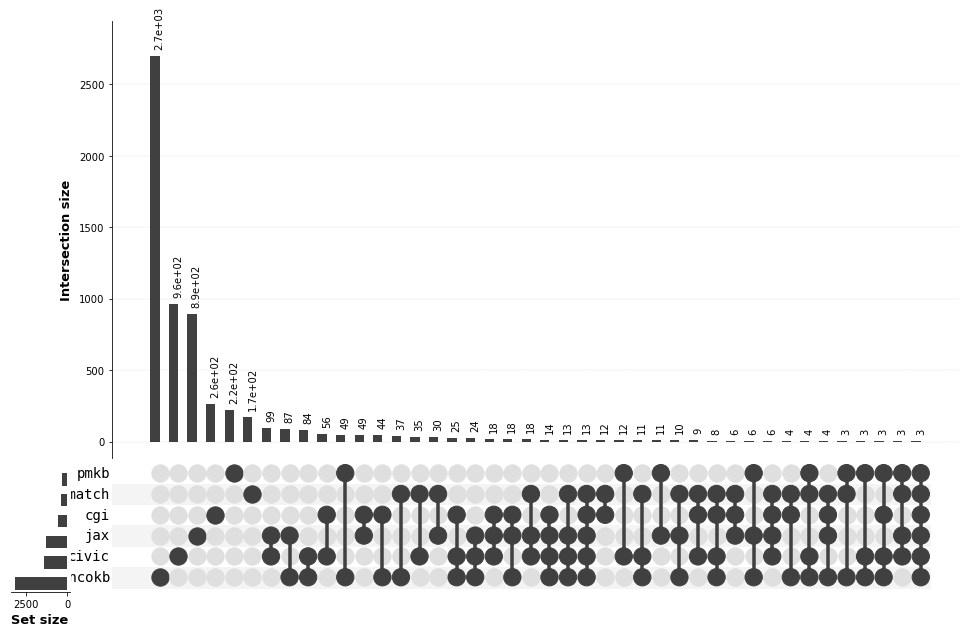

In [52]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g]), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = column_names, inters_size_bounds=(3, 4000))

plot_overlap(source_pmids)
plt.pyplot.savefig('pmids.png')

#plot_overlap({k: v for k, v in source_pmids.items() if k != 'molecularmatch'})

Parse PMIDs specifically for each source, see if differences exist.

Connect PMIDs to genes, phenotypes, gene + phenotype

In [53]:
pmid_dict = defaultdict(lambda: defaultdict(list))
for hit in res['hits']['hits']:
    pmids = hit.get('merged',{}).get('pmids',[])
    for pmid in pmids:
        pmid_dict[pmid][hit['_source']['source']].append(hit['merged'])

In [54]:
print(len(pmid_dict))
print([k for k in pmid_dict.keys() if len(pmid_dict[k]) == 6])

6055
['23220880', '22277784', '20979473']


In [55]:
multi_hit_pmids = {x: v for x, v in pmid_dict.items() if len(v) > 1}
len(multi_hit_pmids)

847

In [56]:
multi_hit_pmids['24569458']

defaultdict(list,
            {'cgi': [{'gene': 'ARAF',
               'phenotype': 'DOID:3910',
               'pmids': ['24569458']}],
             'civic': [{'gene': 'ARAF',
               'phenotype': 'DOID:3908',
               'pmids': ['24569458']},
              {'gene': 'ARAF',
               'phenotype': 'DOID:3908',
               'pmids': ['24569458']},
              {'gene': 'ARAF',
               'phenotype': 'DOID:3908',
               'pmids': ['24569458']}],
             'oncokb': [{'gene': 'ARAF',
               'phenotype': 'DOID:162',
               'pmids': ['24569458', '15520807', '26566875']},
              {'gene': 'ARAF',
               'phenotype': 'DOID:162',
               'pmids': ['24569458', '15520807']},
              {'gene': 'RAF1',
               'phenotype': 'DOID:162',
               'pmids': ['12077328', '7867061', '24569458', '17603483']},
              {'gene': 'ARAF',
               'phenotype': 'DOID:3405',
               'pmids': ['24569458']}

In [57]:
multi_hit_normalized = dict()
for pmid, source_dict in multi_hit_pmids.items():
    new_source_dict = dict()
    for source, associations in source_dict.items():
        filtered_associations = [x for x in associations if 'phenotype' in x]
        if any(filtered_associations):
            new_source_dict[source] = filtered_associations
    if len(new_source_dict) > 1:
        multi_hit_normalized[pmid] = new_source_dict
len(multi_hit_normalized)

801

In [58]:
def g_p_associations(associations):
    new_assoc = list()
    for association in associations:
        new_assoc.append((association['gene'], association['phenotype']))
    return set(new_assoc)

source_pairs = Counter()
pair_complete_matches = Counter()
pair_partial_matches = Counter()
pair_no_matches = Counter()
for pmid, source_dict in multi_hit_normalized.items():
    sources = sorted(source_dict)
    for i, source in enumerate(sources, start=1):
        for j in range(i, len(sources)):
            source2 = sources[j]
            source_pairs[(source, source2)] += 1
            source_gp_assoc = g_p_associations(source_dict[source])
            source2_gp_assoc = g_p_associations(source_dict[source2])
            if source_gp_assoc == source2_gp_assoc:
                pair_complete_matches[(source, source2)] += 1
            elif any(source_gp_assoc & source2_gp_assoc):
                pair_partial_matches[(source, source2)] += 1
            else:
                pair_no_matches[(source, source2)] += 1
                print("=====\n{}: {}\n{}: {}".format(source, source_gp_assoc, source2, source2_gp_assoc))

=====
cgi: {('KRAS', 'DOID:1324')}
molecularmatch: {('KRAS', 'DOID:3910')}
=====
jax: {('EGFR|NRAS', 'DOID:3908'), ('EGFR', 'DOID:3908'), ('EGFR|KRAS', 'DOID:3908'), ('EGFR', 'DOID:3910')}
molecularmatch: {('KRAS', 'DOID:3910')}
=====
civic: {('KRAS', 'DOID:3908')}
jax: {('KRAS', 'DOID:3910')}
=====
civic: {('KRAS', 'DOID:3908')}
molecularmatch: {('KRAS', 'DOID:3910')}
=====
civic: {('KRAS', 'DOID:3908')}
pmkb: {('KRAS', 'DOID:299')}
=====
jax: {('KRAS', 'DOID:3910')}
pmkb: {('KRAS', 'DOID:299')}
=====
molecularmatch: {('KRAS', 'DOID:3910')}
pmkb: {('KRAS', 'DOID:299')}
=====
civic: {('ALK', 'DOID:769')}
molecularmatch: {('ALK', 'DOID:3910')}
=====
cgi: {('ALK', 'DOID:3910')}
civic: {('ALK', 'DOID:3908')}
=====
cgi: {('ALK', 'DOID:3910')}
oncokb: {('ALK', 'DOID:162')}
=====
civic: {('ALK', 'DOID:3908')}
jax: {('ALK', 'DOID:3910'), ('ALK|EML4', 'DOID:3908'), ('ALK|EML4', 'DOID:162')}
=====
civic: {('ALK', 'DOID:3908')}
molecularmatch: {('ALK', 'DOID:3910')}
=====
civic: {('ALK', 'DOID:3

In [59]:
print(pair_complete_matches)
print(pair_partial_matches)
print(pair_no_matches)

Counter({('civic', 'jax'): 58, ('jax', 'oncokb'): 31, ('cgi', 'civic'): 27, ('civic', 'molecularmatch'): 21, ('cgi', 'molecularmatch'): 19, ('cgi', 'jax'): 10, ('civic', 'oncokb'): 7, ('cgi', 'oncokb'): 6, ('jax', 'molecularmatch'): 5, ('civic', 'pmkb'): 3})
Counter({('civic', 'jax'): 61, ('jax', 'oncokb'): 34, ('civic', 'pmkb'): 16, ('cgi', 'jax'): 14, ('jax', 'molecularmatch'): 14, ('civic', 'oncokb'): 13, ('cgi', 'civic'): 13, ('civic', 'molecularmatch'): 12, ('cgi', 'oncokb'): 10, ('jax', 'pmkb'): 9, ('cgi', 'molecularmatch'): 6, ('molecularmatch', 'oncokb'): 3, ('cgi', 'pmkb'): 3, ('oncokb', 'pmkb'): 2})
Counter({('civic', 'oncokb'): 182, ('jax', 'oncokb'): 132, ('molecularmatch', 'oncokb'): 109, ('cgi', 'oncokb'): 102, ('civic', 'jax'): 96, ('civic', 'molecularmatch'): 92, ('jax', 'molecularmatch'): 91, ('cgi', 'jax'): 91, ('cgi', 'civic'): 89, ('oncokb', 'pmkb'): 78, ('cgi', 'molecularmatch'): 34, ('jax', 'pmkb'): 22, ('molecularmatch', 'pmkb'): 20, ('civic', 'pmkb'): 14, ('cgi'

In [60]:
pair_no_matches

Counter({('cgi', 'civic'): 89,
         ('cgi', 'jax'): 91,
         ('cgi', 'molecularmatch'): 34,
         ('cgi', 'oncokb'): 102,
         ('cgi', 'pmkb'): 7,
         ('civic', 'jax'): 96,
         ('civic', 'molecularmatch'): 92,
         ('civic', 'oncokb'): 182,
         ('civic', 'pmkb'): 14,
         ('jax', 'molecularmatch'): 91,
         ('jax', 'oncokb'): 132,
         ('jax', 'pmkb'): 22,
         ('molecularmatch', 'oncokb'): 109,
         ('molecularmatch', 'pmkb'): 20,
         ('oncokb', 'pmkb'): 78})